In [1]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

In [3]:
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cude:{device_id}' # cuda:1 id GPU
n_epochs = 10
batch_size = 128

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
    ]
)

dataset_train = datasets.MNIST('.', 
                                train=True,
                                download=True,
                                transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=2,
                                        drop_last=True,)
dataset_test = datasets.MNIST('.',
                            train=False,
                            download=True,
                            transform=transform)
testloader = torch.utils.data.DataLoader(dataset_train,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=2,
                                        drop_last=True,)

In [33]:
dataset_train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

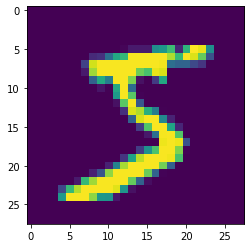

In [5]:
import matplotlib.pyplot as plt

plt.imshow(dataset_train.data[0].detach().numpy())
plt.show()

In [5]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1) -> None:
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        #custom init: nn.init.xavier_normal_(self.linear.weight)
        self.do1 = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.do1(x)
        x = self.linear2(x)

        return x

In [6]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
model.train()
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [13]:
# Как форм. батч
# dataloader берет из sampler набор индексов и по этим индексам получает эл-ты из Dataset

def collate_fn(data: list):
    # data = [(pic, target)...]
    pics = []
    target = []
    for item in data:
        pics.append(numpy.array(item[0]))
        target.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() # B x W x H
    target = torch.from_numpy(numpy.array(target)).type(torch.LongTensor)

    return {
        'data': pics.view(pics.size(0), -1), # B x 7xx преобразуем матрицу 28х28 в вектор 7хх
        'target': target,
        }
        
dataloader = DataLoader(dataset_train, 
                        batch_size, 
                        shuffle=True, 
                        collate_fn=collate_fn,
                        drop_last = True,
                        )
for epoch in range(n_epochs):
    
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

epoch: 0, step: 0, loss: 2.3654801845550537
epoch: 0, step: 200, loss: 0.3303302526473999
epoch: 0, step: 400, loss: 0.28192397952079773
epoch: 1, step: 0, loss: 0.3811625838279724
epoch: 1, step: 200, loss: 0.33042198419570923
epoch: 1, step: 400, loss: 0.20368735492229462
epoch: 2, step: 0, loss: 0.10563197731971741
epoch: 2, step: 200, loss: 0.15710918605327606
epoch: 2, step: 400, loss: 0.12734121084213257
epoch: 3, step: 0, loss: 0.18564029037952423
epoch: 3, step: 200, loss: 0.0924237072467804
epoch: 3, step: 400, loss: 0.10415872931480408
epoch: 4, step: 0, loss: 0.08158305287361145
epoch: 4, step: 200, loss: 0.12703637778759003
epoch: 4, step: 400, loss: 0.09750518202781677
epoch: 5, step: 0, loss: 0.13338172435760498
epoch: 5, step: 200, loss: 0.0800875797867775
epoch: 5, step: 400, loss: 0.151255264878273
epoch: 6, step: 0, loss: 0.053298622369766235
epoch: 6, step: 200, loss: 0.09417596459388733
epoch: 6, step: 400, loss: 0.1196545735001564
epoch: 7, step: 0, loss: 0.0728824

In [ ]:
# или так
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model(inputs.view(inputs.size(0), -1).to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

## Conv

In [7]:
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [8]:
class ConvBNDO(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, stride, padding, 
                 dropout_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(input_ch, output_ch, kernel_size=kernel_size, 
                              stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(output_ch)
        self.do = nn.Dropout(dropout_p)
        self.activ= nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activ(x)
        x = self.do(x)

        return x

class ConvModel(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.convbn1 = ConvBNDO(input_ch, hidden_ch, kernel_size=5, stride=2, 
                                padding=2) # 28x28 -> 14x14
        self.convbn2 = ConvBNDO(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                                padding=1)
        self.conv = nn.Conv2d(hidden_ch, 10, kernel_size=3, stride=1, 
                                padding=1)
        self.clf = nn.Linear(10 * 14 *14, output_dim)        

    def forward(self, x):
        x = self.convbn1(x)
        x = self.convbn2(x)
        x = self.conv(x)
        x = self.clf(x.view(x.size(0), -1))

        return x

In [9]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        #if epoch == 0:
            #print(f'step {i}, size = {inputs.shape}, inputs = {inputs}')
        optim.zero_grad()

        predict = model_conv(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #test model
    for i, batch in enumerate(testloader):
        inputs, labels = batch

        model_conv.eval()
        loss_test = 0
        with torch.no_grad():
            predict = model_conv(inputs.to(device))
            loss_test += loss_func(predict, labels.to(device))
    
    model_conv.train()
    # print('test loss:', loss_test / i)
    #save every epoch

    torch.save(model_conv.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')

# Задание 1. ResNet18 on CIFAR10

In [15]:
input_ch = 3
hidden_ch = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001C5B6EB1160>
Traceback (most recent call last):
  File "c:\Users\ciril\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "c:\Users\ciril\anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 1468, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


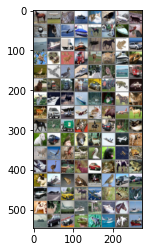

horse plane cat   ship  cat   deer  plane cat   bird  cat   plane ship  horse cat   ship  cat   ship  ship  truck ship  cat   horse frog  car   bird  deer  deer  truck horse cat   ship  frog  bird  plane bird  plane truck bird  ship  truck horse truck truck horse car   horse frog  car   deer  ship  deer  ship  deer  cat   horse cat   deer  car   plane plane cat   deer  plane horse horse bird  truck cat   horse car   deer  cat   dog   truck bird  bird  deer  plane plane dog   deer  plane horse horse bird  dog   plane frog  ship  bird  deer  deer  car   frog  horse frog  dog   truck frog  cat   horse bird  truck plane car   plane car   deer  plane bird  frog  cat   dog   deer  plane ship  deer  ship  horse ship  ship  car   car   frog  frog  plane cat   ship 


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

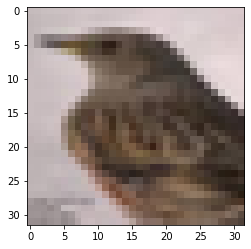

In [18]:
plt.imshow(trainset.data[18])

In [19]:
class ConvBNDO(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, stride, padding, 
                 dropout_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(input_ch, output_ch, kernel_size=kernel_size, 
                              stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(output_ch)
        self.do = nn.Dropout(dropout_p)
        self.activ= nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activ(x)
        x = self.do(x)

        return x

class ConvModel(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.convbn1 = ConvBNDO(input_ch, hidden_ch, kernel_size=5, stride=2, 
                                padding=2) # 28x28 -> 14x14
        self.convbn2 = ConvBNDO(hidden_ch, hidden_ch, kernel_size=3, stride=1, 
                                padding=1)
        self.conv = nn.Conv2d(hidden_ch, 15, kernel_size=3, stride=1, 
                                padding=1)
        self.clf = nn.Linear(15 * 14 *14, output_dim)        

    def forward(self, x):
        x = self.convbn1(x)
        x = self.convbn2(x)
        x = self.conv(x)
        x = self.clf(x.view(x.size(0), -1))

        return x

In [20]:
class ResNet(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(input_ch, np.int8(hidden_ch/2), kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(np.int8(hidden_ch/2), hidden_ch, kernel_size=5)
        self.clf1 = nn.Linear(hidden_ch * 5 * 5, 120)  
        self.clf2 = nn.Linear(120, 50) 
        self.clf3 = nn.Linear(50, output_dim)

        self.activ= nn.ReLU()

    def forward(self, x):
        x = self.pool(self.activ(self.conv1(x)))
        x = self.pool(self.activ(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activ(self.clf1(x))
        x = self.activ(self.clf2(x))
        x = self.clf3(x)

        return x

In [21]:
model_conv_cifar10 = ResNet(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv_cifar10.parameters())
loss_func = nn.CrossEntropyLoss()

In [22]:
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        #if epoch == 0:
            #print(f'step {i}, size = {inputs.shape}, inputs = {inputs}')
        optim.zero_grad()

        predict = model_conv_cifar10(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    #test model
    for i, batch in enumerate(testloader):
        inputs, labels = batch

        model_conv_cifar10.eval()
        loss_test = 0
        with torch.no_grad():
            predict = model_conv_cifar10(inputs.to(device))
            loss_test += loss_func(predict, labels.to(device))
    
    model_conv_cifar10.train()
    # print('test loss:', loss_test / i)
    #save every epoch

    torch.save(model_conv_cifar10.state_dict(), f'./chkpt_cv1_conv_c10_{epoch}.pth')

epoch: 0, step: 0, loss: 2.3087055683135986
epoch: 0, step: 200, loss: 1.516778826713562
epoch: 1, step: 0, loss: 1.2632384300231934
epoch: 1, step: 200, loss: 1.2485922574996948
epoch: 2, step: 0, loss: 0.9657216668128967
epoch: 2, step: 200, loss: 0.9139910936355591
epoch: 3, step: 0, loss: 0.8250335454940796
epoch: 3, step: 200, loss: 0.8167731761932373
epoch: 4, step: 0, loss: 0.7334258556365967
epoch: 4, step: 200, loss: 0.7809369564056396
epoch: 5, step: 0, loss: 0.6651055216789246
epoch: 5, step: 200, loss: 0.5166763663291931
epoch: 6, step: 0, loss: 0.6750138401985168
epoch: 6, step: 200, loss: 0.6460297107696533
epoch: 7, step: 0, loss: 0.5005016922950745
epoch: 7, step: 200, loss: 0.507506251335144
epoch: 8, step: 0, loss: 0.3713547885417938
epoch: 8, step: 200, loss: 0.45424309372901917
epoch: 9, step: 0, loss: 0.3602885603904724
epoch: 9, step: 200, loss: 0.3351409137248993
